In [1]:
import uproot 
import numpy as np
import coffea
from coffea.nanoaod import NanoEvents
from coffea.nanoaod.methods.leptons import *
from coffea import hist
import matplotlib.pyplot as plt

In [2]:
fname="/uscms/home/therwig/nobackup/public/forDominic/CRAB3_sos_28may2020_testHinoProd_nano.root"
events = NanoEvents.from_file(fname,methods={"ElectronBPark":Electron})

In [3]:
def makeroc(sig, bkg, binning, direction=1):
    '''Given a signal and background discriminant array, along with a binning,
    compute the ROC curve by integrating discriminant histograms along a direction:
        1: cut < value
        -1: cut >= value
    Returns a tuple of (signal efficiency, background efficiency)'''
    sighist, _ = np.histogram(sig, bins=binning)
    bkghist, _ = np.histogram(bkg, bins=binning)
    # numpy histogram will ignore values out of range of our binning (overflow)
    # so add the overflow values that would pass given our cut direction
    if direction == 1:
        sighist[0] += sum(sig < binning[0])
        bkghist[0] += sum(bkg < binning[0])
    elif direction == -1:
        sighist[-1] += sum(sig > binning[-1])
        bkghist[-1] += sum(bkg > binning[-1])
    else:
        raise ValueError("Invalid direction")
    sigpass = (np.cumsum(sighist[::direction]) / len(sig))[::direction]
    bkgpass = (np.cumsum(bkghist[::direction]) / len(bkg))[::direction]
    return (sigpass, bkgpass)


def cut(electrons):
    return electrons[
        (electrons.pt > 1)
        & (abs(electrons.eta) < 1.4) & (electrons.pt<5)
    ]


In [4]:
eles = events.ElectronBPark.cross(events.GenPart[events.GenPart.pdgId == 11], nested=True)
mask = ((eles.i0.delta_r(eles.i1)).min() < 0.05) & (events.ElectronBPark.pt<5) & (events.ElectronBPark.pt>1)

matched_electrons = events.ElectronBPark[mask].flatten()
unmatched_electrons = events.ElectronBPark[~mask].flatten()

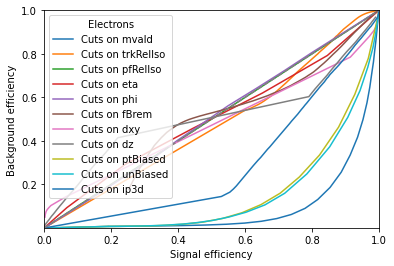

In [5]:
#compare discrimating variables
roc_mva = makeroc(
    sig=cut(matched_electrons).mvaId,
    bkg=cut(unmatched_electrons).mvaId,
    binning=np.linspace(-10, 30, 80),
    direction=-1,
)

roc_trkRelIso = makeroc(
    sig=cut(matched_electrons).trkRelIso,
    bkg=cut(unmatched_electrons).trkRelIso,
    binning=np.linspace(-0.1, 30, 800),
    direction=1,
)

roc_pfRelIso = makeroc(
    sig=cut(matched_electrons).pfRelIso,
    bkg=cut(unmatched_electrons).pfRelIso,
    binning=np.linspace(-30, 30, 800),
    direction=-1,
)

roc_eta = makeroc(
    sig=cut(matched_electrons).eta,
    bkg=cut(unmatched_electrons).eta,
    binning=np.linspace(-10, 30, 80),
    direction=-1,
)

roc_phi = makeroc(
    sig=cut(matched_electrons).phi,
    bkg=cut(unmatched_electrons).phi,
    binning=np.linspace(-10, 30, 80),
    direction=-1,
)

roc_fBrem = makeroc(
    sig=cut(matched_electrons).fBrem,
    bkg=cut(unmatched_electrons).fBrem,
    binning=np.linspace(0, 1, 80),
    direction=1,
)

roc_dxy = makeroc(
    sig=cut(matched_electrons).dxy,
    bkg=cut(unmatched_electrons).dxy,
    binning=np.linspace(-1, 1, 80),
    direction=-1,
)

roc_dz = makeroc(
    sig=cut(matched_electrons).dz,
    bkg=cut(unmatched_electrons).dz,
    binning=np.linspace(-10, 30, 80),
    direction=-1,
)

roc_ptBiased = makeroc(
    sig=cut(matched_electrons).ptBiased,
    bkg=cut(unmatched_electrons).ptBiased,
    binning=np.linspace(-10, 30, 80),
    direction=-1,
)

roc_unBiased = makeroc(
    sig=cut(matched_electrons).unBiased,
    bkg=cut(unmatched_electrons).unBiased,
    binning=np.linspace(-10, 30, 80),
    direction=-1,
)

roc_ip3d = makeroc(
    sig=cut(matched_electrons).ip3d,
    bkg=cut(unmatched_electrons).ip3d,
    binning=np.linspace(-30, 30, 800),
    direction=1,
)


fig, ax = plt.subplots()
ax.plot(*roc_mva, label=r"Cuts on mvaId")
ax.plot(*roc_trkRelIso, label=r"Cuts on trkRelIso")
ax.plot(*roc_pfRelIso, label=r"Cuts on pfRelIso")
ax.plot(*roc_eta, label=r"Cuts on eta")
ax.plot(*roc_phi, label=r"Cuts on phi")
ax.plot(*roc_fBrem, label=r"Cuts on fBrem")
ax.plot(*roc_dxy, label=r"Cuts on dxy")
ax.plot(*roc_dz, label=r"Cuts on dz")
ax.plot(*roc_ptBiased, label=r"Cuts on ptBiased")
ax.plot(*roc_unBiased, label=r"Cuts on unBiased")
ax.plot(*roc_ip3d, label=r"Cuts on ip3d")
diag = np.linspace(0, 1, 100)
ax.plot(diag, diag, color='grey', linestyle='--')
ax.set_xlabel("Signal efficiency")
ax.set_ylabel("Background efficiency")
ax.set_xlim(0, 1)
ax.set_ylim(1e-3, 1)
# ax.set_yscale('log')
ax.legend(title=r'Electrons')

In [6]:
events.ElectronBPark.columns

['dxy',
 'dxyErr',
 'dz',
 'dzErr',
 'eta',
 'fBrem',
 'ip3d',
 'mass',
 'mvaId',
 'pfRelIso',
 'pfmvaId',
 'phi',
 'pt',
 'ptBiased',
 'sip3d',
 'trkRelIso',
 'unBiased',
 'vx',
 'vy',
 'vz',
 'charge',
 'pdgId',
 'convVeto',
 'isLowPt',
 'isPF',
 'isPFoverlap',
 'genPartFlav',
 'matched_jet',
 'matched_gen',
 'matched_photon']

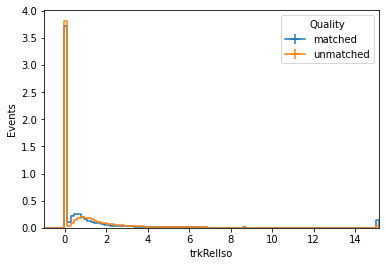

In [7]:
histo9 = hist.Hist(
            "Events",
            hist.Cat("quality", "Quality"),
            hist.Bin("soft_unmatched_ele", "trkRelIso", 100, -1, 15),
        )

histo9.fill(quality ="unmatched", soft_unmatched_ele=unmatched_electrons.trkRelIso)
histo9.fill(quality ="matched", soft_unmatched_ele=matched_electrons.trkRelIso)


%matplotlib inline
hist.plot1d(histo9, overflow = "over", density = True)
